# Twitter Bot Detection Demo

## Written by C.J. Sullivan
### [My GitHub site](https://github.com/cj2001)
### [My LinkedIn profile](https://www.linkedin.com/in/clair-sullivan-09914342/)
### Email: cj2001@gmail.com

The purpose of the demonstration is to provide a walk-through of my machine learning thought processes around a classification problem.  I chose the detection of bot accounts on Twitter for this demonstration.  The data for this demonstration can be found on Kaggle [here](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts).  The columns of this data set are:

- Index
- `created_at`: when the account was created (datetime)
- `default_profile`: whether the account is using a default profile (boolean)
- `default_profile_image`: whether the account has a default image profile (boolean)
- `description`: user account description (str)
- `favourties_count`: total number of favourite tweets (int)
- `followers_count`: total number of followers of the account (int)
- `friends_count`: total number of friends of the account (int)
- `geo_enabled`: whether the account has the geographic location enabled (boolean)
- `id`: unique account identifier (int)
- `language`: 2-letter identifier of the language associated with the account (str)
- `location`: location in the world of the account (str)
- `profile_background_image_url`: if present, the URL to the profile background image (str)
- `screen_name`: the Twitter handle (str)
- `statuses_count`: total number of tweets by the account (int)
- `verified`: whether the account is a verified account or not (boolean)
- `average_tweets_per_day`: average number of tweets per day (int)
- `account_age_days`: the age of the account in days (int)
- `account_type`: label identifying whether the account is a "bot" or "human" (str)

For the purpose of this demonstration I will not be doing any natural language processing (NLP) on the string columns.  While this has the potential to increase the accuracy, I am intending this to provide a basic demonstration of an ML classifier and my thought process around creating it.  I will provide a demonstration of an NLP problem on a different dataset and in a different repository.

Additionally, for the sake of simplicity I will be using traditional ML approaches (i.e. `scikit-learn`) rather than deep learning (DL) approaches such as TensorFlow or PyTorch.  My philosophy is that I start with the simplest method and expand into DL if traditional ML is not providing results of sufficient quality.

Lastly, this notebook will be full of comments to document my thought processes.  I apologize in advance for its length as a result!  :)

In [1]:
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('./twitter_human_bots_dataset.csv', index_col=0)  # This data was downloaded in advance
df.head()

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [3]:
print("DataFrame shape: ", df.shape)

DataFrame shape:  (37438, 19)


In [4]:
df['account_type'].value_counts()

human    25013
bot      12425
Name: account_type, dtype: int64

## Note on class imbalance

We can see in the above that there are approximately twice as many humans as bots in our data set.  This is not a good thing.  However I have not elected to attempt to solve it since the difference is still within the same order of magnitude.  There are a variety of techniques to solve this problem including but not limited to:

- Choosing appropriate metrics for evaluating models
- Resampling data
- Generating synthetic samples

## Some brief exploratory data analysis (EDA)

We will first drop the columns associated with text data that would require NLP approaches.  We will also identify if there are columns that have a lot of NA's associated with them and drop those as well.

In [5]:
df.isna().sum()

created_at                         0
default_profile                    0
default_profile_image              0
description                     7256
favourites_count                   0
followers_count                    0
friends_count                      0
geo_enabled                        0
id                                 0
lang                            7957
location                           3
profile_background_image_url    4499
profile_image_url                  1
screen_name                        0
statuses_count                     0
verified                           0
average_tweets_per_day             0
account_age_days                   0
account_type                       0
dtype: int64

In [6]:
df2 = df.drop(['created_at', 'description', 'id', 'lang', 'profile_background_image_url',
               'profile_image_url', 'location', 'screen_name'], axis=1)
df2.head()

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,False,False,4,1589,4,False,11041,False,7.870,1403,bot
1,False,False,536,860,880,False,252,False,0.183,1379,human
2,False,False,3307,172,594,True,1001,False,0.864,1159,human
3,True,False,8433,517,633,True,1324,False,0.889,1489,human
4,False,False,88,753678,116,True,4202,True,1.339,3138,human


## Some data preprocessing

We would like to convert the boolean columns to actual numbers for their ability to be included in our future models.  We also would like to encode the "bot"/"human" label.

In [8]:
def convert_bool_to_float(data: pd.DataFrame, boolean_cols: list):
    try:
        for col in boolean_cols:
            data[col] = data[col].astype(float)
    except Exception as e:
        print(e)
    return data


def encode_account(account_type: str):
    
    try:
        if account_type == 'bot':
            return 1
        elif account_type == 'human':
            return 0
    except Exception as e:
        print(e)
        
    return


boolean_cols: list = ["default_profile", "default_profile_image",
                      "geo_enabled", "verified"]
    
df2 = convert_bool_to_float(data=df2, boolean_cols=boolean_cols)
df2['account_type'] = df['account_type'].map(encode_account)
df2.head()

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0.0,0.0,4,1589,4,0.0,11041,0.0,7.870,1403,1
1,0.0,0.0,536,860,880,0.0,252,0.0,0.183,1379,0
2,0.0,0.0,3307,172,594,1.0,1001,0.0,0.864,1159,0
3,1.0,0.0,8433,517,633,1.0,1324,0.0,0.889,1489,0
4,0.0,0.0,88,753678,116,1.0,4202,1.0,1.339,3138,0


## Correlation of variables

We will now explore whether there are any obvious correlations between variables of the above...

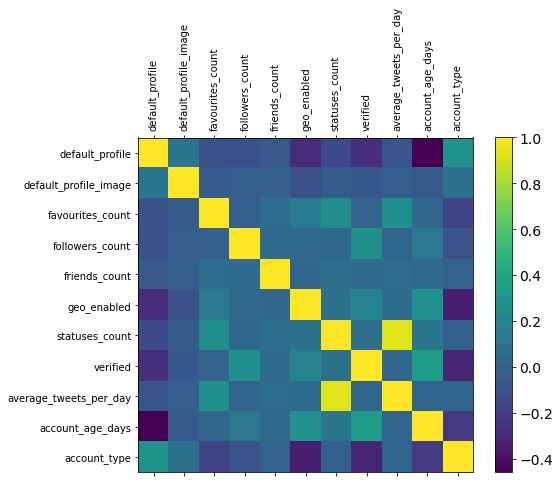

In [9]:
f = plt.figure(figsize=(8, 6))
plt.matshow(df2.corr(), fignum=f.number)
plt.xticks(range(df2.shape[1]), df2.columns, fontsize=10, rotation=90)
plt.yticks(range(df2.shape[1]), df2.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

We see one apparent correlation between `average_tweets_per_day` and `statuses_count`.  This is not particularly surprising and we need to evaluate whether we want to eliminate one of these variables as a result.

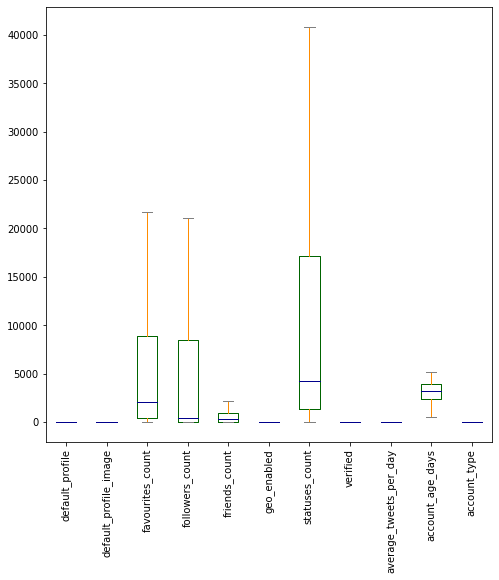

In [10]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
df2.plot.box(color=color, sym='r+', figsize=(8,8), showfliers=False, rot=90)

We can see above that many of these variables, `statuses_count` most notably, do not have a symmetric Gaussian shape.  So it might not be a good idea to eliminate this variable in place of `average_tweets_per_day` since there might be insufficient modeling in that term of an assumed Gaussian distribution.  

We can also explore this plot in a more detailed way:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13884ce90>,
      dtype=object)

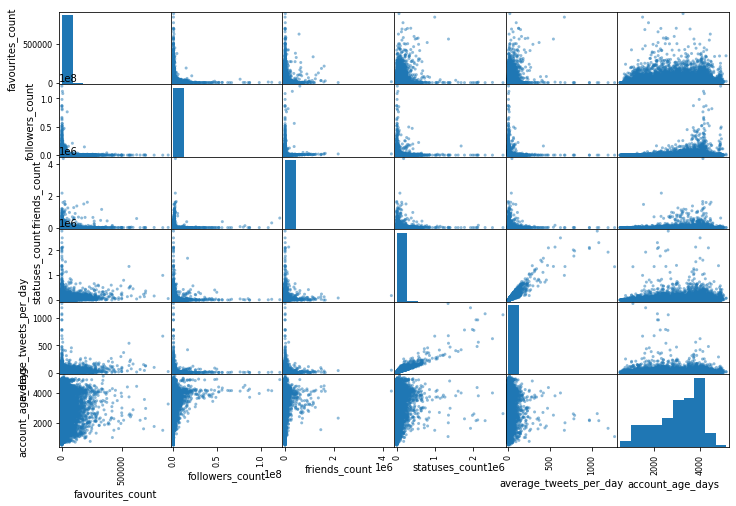

In [11]:
attributes = ['favourites_count', 'followers_count',
              'friends_count', 'statuses_count', 'average_tweets_per_day',
              'account_age_days']

scatter_matrix(df2[attributes], figsize=(12,8))

As is clear from the diagonal, most of these variables are not Gaussian in shape.  So I have decided to keep them all in this model.  The removal of one of them (example: `statuses_count` or `average_tweets_per_day`) is something that could be eventually considered in the fine-tuning of the model, but I will not do it here.

## Data normalization

We can see in the above figures that not all variables are on similar scales.  This is bad for ML models in that the model could tune itself to the variables of large value, ignoring the small ones.  Also, model solutions can become mathematically unstable as the individual variables get very large.  Thus it is ideal to attempt to normalize each column.  In this, I will be using the simple min-max normalization.

In [14]:
def data_scaler(df: pd.DataFrame, col_name: str):
    
    min_max_scaler = preprocessing.MinMaxScaler()
    float_array = df[col_name].values.astype(float).reshape(-1,1)
    scaled_array = min_max_scaler.fit_transform(float_array)
    df[col_name] = scaled_array
    
    return df

columns_to_be_scaled = ['favourites_count', 'followers_count', 'friends_count', 'statuses_count',
                        'average_tweets_per_day', 'account_age_days']

for col in columns_to_be_scaled:
    df2 = data_scaler(df2, col)

df2.head()

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0.0,0.0,0.000005,0.000013,9.210096e-07,0.0,0.003983,0.0,0.006201,0.196791,1
1,0.0,0.0,0.000606,0.000007,2.026221e-04,0.0,0.000091,0.0,0.000144,0.191658,0
2,0.0,0.0,0.003736,0.000001,1.367699e-04,1.0,0.000361,0.0,0.000681,0.144599,0
3,1.0,0.0,0.009527,0.000004,1.457498e-04,1.0,0.000478,0.0,0.000701,0.215187,0
4,0.0,0.0,0.000099,0.006196,2.670928e-05,1.0,0.001516,1.0,0.001055,0.567914,0


## Creation of the initial model

As stated before, I prefer to start with a simple model and select more complicated ones should the simple model not perform well.  In this case, Random Forest Classification (RFC) is a good starting point.  

For model evaluation, I will break the data into a train-test split where 75% of the data is randomly selected for training while the other 25% is held out for evaluation.

In [15]:
X = df2[['default_profile', 'default_profile_image', 'favourites_count', 'followers_count',
         'friends_count', 'geo_enabled', 'statuses_count', 'verified', 'average_tweets_per_day',
         'account_age_days']]
y = df2['account_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)

In [16]:
rfc=RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred), '\n')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Accuracy_score: ', accuracy_score(y_test,y_pred))

Confusion Matrix:
[[17493  1323]
 [ 2290  6973]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     18816
           1       0.84      0.75      0.79      9263

    accuracy                           0.87     28079
   macro avg       0.86      0.84      0.85     28079
weighted avg       0.87      0.87      0.87     28079

Accuracy_score:  0.8713273264717405


This simple model has achieved an accuracy of 87%, which is rather good for a first attempt.  It also might be worth considering that accuracy is not always the best indicator for an imbalanced data set, as mentioned above.  The use of precision, recall, and the F1 score can be better suited for this task.

## Cross validation and model tuning

The above represents the most simplistic of models with a single, tunable parameter: `n_estimators`.  This value was just one that I chose, and might not represent the best solution.  

Additionally, a single view of the data set was chosen for the training of the model.  A more robust model might consider multiple representations of that data set for cross validation purposes (K-Fold cross validation).

Below I will both evaluate some of the tunable parameters of the RFC model while also performing cross validation on 5 folds of data using the simple K-Folds approach.  There are several other cross validation approaches, but I will keep it simple for this demonstration.

In [17]:
rfc_cv=RandomForestClassifier()
param_grid = { 
    'n_estimators': [100, 200, 400],
    'criterion' :['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

CV_rfc = GridSearchCV(estimator=rfc_cv, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

We have now identified through a grid search and 5-fold cross validation the optimal parameters, given the set of those we wished to tune, for this model.  We will now attempt to see if it performs any better than our simple model.

In [18]:
rfc_opt = RandomForestClassifier(criterion='gini', max_depth=8, max_features='log2', n_estimators=200)
rfc_opt.fit(X_train, y_train)
y_pred=rfc_opt.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred), '\n')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Accuracy_score: ', accuracy_score(y_test,y_pred))

Confusion Matrix:
[[17420  1396]
 [ 2610  6653]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18816
           1       0.83      0.72      0.77      9263

    accuracy                           0.86     28079
   macro avg       0.85      0.82      0.83     28079
weighted avg       0.86      0.86      0.85     28079

Accuracy_score:  0.857331101534955


While we note some very slight decreases in our metrics, this is likely lost in the noise, associated with different random number generators.

## Trying a new model

Linear Support Vector Classifiers (SVCs) also present a good model, particularly when the number of samples is smaller (< 100,000).  So let's see if they can perform better than the above RFC.

In [19]:
svc = SVC(C=1.0, kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred), '\n')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Accuracy_score: ', accuracy_score(y_test,y_pred))

Confusion Matrix:
[[12956  5860]
 [ 2122  7141]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.69      0.76     18816
           1       0.55      0.77      0.64      9263

    accuracy                           0.72     28079
   macro avg       0.70      0.73      0.70     28079
weighted avg       0.76      0.72      0.72     28079

Accuracy_score:  0.7157306171872218


As we can see here, many of our metrics dropped significantly.  We could also try to run the above grid search and cross validation, but since the basic SVC model failed to perform as well as the RFC, I will not do that at this time.

## Concluding thoughts

In the above demonstration I have shown the application of two different models to the problem of Twitter bot detection.  There are several things I could have done different that might improve the model's overall performance:

1. We eliminated all text from the model.  NLP could provide a very rich opportunity for bot detection and the use might improve the overall results.  All of the above terms could possibly be eliminated in favor of an approach that was 100% based on NLP.  However, there are many missing data points in the data set (see the Kaggle documentation) to the point where this could impact the overall results.  A larger data set should be used in that approach.

2. There were a few approaches that we used that assumed Gaussian distributions on the data that we know to be bad assumptions (example: `MinMaxScaler()`).  These assumptions should likely be revisited to see if they improve the overall results.

## A note on metrics as applied to the needs of the problem

I looked at overall accuracy, precision, recall, and F1 scores and treated them all the same.  However, the customer might not see it that way.  One customer might care about accuracy while the other one simply wants to limit false positives.  This type of customer-based insight will guide model selection and should not be discounted.